# Projet 5GMM

In [1]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import csv
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import pandas as pd
import seaborn as sns
import random
from sklearn import linear_model

C:\Users\Lilian Beuneche\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
#Fonction pour lire les données dans le CSV et les transformer en un tableau de nombres
def lire_csv(Nom):
    fichier_lire=open(Nom)

    fichier=csv.reader(fichier_lire, delimiter=",")
    fichier=list(fichier)
    tab2=np.array(fichier)
    #tab2=np.delete(tab2, (0),axis=0)
    
    for i in range(0,np.shape(tab2)[0]):
        for j in range(2,10):
            tab2[i][j]=np.copy(float(tab2[i][j].replace(",",".")))
       
    return tab2;

In [3]:
#Data est le tableau de toutes les données "train"
Data=lire_csv("blogData_train.csv")
Data=Data.astype(np.float)

In [4]:
#Y est la variable à prédire, ici c'est la 281ème colonne
Y=Data[:,280]
print(Y)

#Mots est la matrice contenant l'apparition ou non apparition des mots clés, ici c'est les colonnes 62 à 262
Mots=Data[:, 62:261]
print(Mots)

#X sans les mots
X_Part1=Data[:,0:61]
X_Part2=Data[:,276:280]
X_SansMots=np.concatenate((X_Part1, X_Part2), axis=1)

[ 1.  0.  0. ...,  0.  0.  0.]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [5]:
stats.describe(Y)

DescribeResult(nobs=52397, minmax=(0.0, 1424.0), mean=6.7647193541614978, variance=1421.7850114550367, skewness=12.691311246278929, kurtosis=232.29540940625407)

In [6]:
Quantile87=np.percentile(Y, 87.5)
print(Quantile87)

6.0


In [7]:
Y_Quali=[]

for i in range(0, np.shape(Y)[0]):
    if Y[i]==0:
        Y_Quali.append(0)
    elif Y[i]==1:
        Y_Quali.append(1)
    elif Y[i]>1 and Y[i]<Quantile87:
        Y_Quali.append(2)
    elif Y[i]>=Quantile87:
        Y_Quali.append(3)

L'autre idée est de transformer nos données avec un logarithme en faisant ln(1+Y)
On remarque que les données sont mieux réparties et donc plus utilisables.

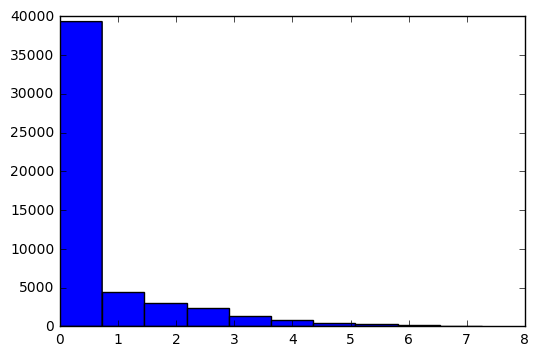

In [8]:
Yln=np.log(1+Y)
plt.hist(Yln)
plt.show()

## Création de l'échantillon test

On sélectionne 10% des données, en prenant en compte les proportions de l'échantillon global

On aura donc 90% des individus pour l'apprentissage (47157)
On aura 10% des invidus pour les tests (5240)

In [9]:
TailleEchantillonApp=47157
TailleEchantillonTest=5240
NbCol=np.shape(X_SansMots)[1]
EchantillonTest=np.zeros((TailleEchantillonTest,NbCol))
EchantillonApp=np.zeros((TailleEchantillonApp,NbCol))
Y_Quali_Test=np.zeros((TailleEchantillonTest,))

In [10]:
ListeTest=random.sample(range(0, np.shape(X_SansMots)[0]), 5240)
j=0
k=0
for i in range(0, np.shape(X_SansMots)[0]):
    if i in ListeTest:
        EchantillonTest[j]=X_SansMots[i,:]
        Y_Quali_Test[j]=Y_Quali[i]
        j+=1
    else :
        EchantillonApp[k]=X_SansMots[i,:]
        k+=1

In [11]:
Donnees_Panda=pd.DataFrame(EchantillonTest)
y_Panda=pd.DataFrame(Y_Quali_Test)

In [12]:
print(np.shape(Donnees_Panda))
print(np.shape(y_Panda))

(5240, 65)
(5240, 1)


## Régression polytomique

In [13]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [78]:
param=[{"C":[1,1.5]}]
polyt = GridSearchCV(LogisticRegression(multi_class='ovr',solver ='liblinear', penalty='l1'), param,cv=5,n_jobs=-1)
polytOpt=polyt.fit(Donnees_Panda,y_Panda)  # GridSearchCV est lui même un estimateur
# paramètre optimal
polytOpt.best_params_["C"]
print("Meilleur score = %f, Meilleur paramètre = %s" % (1.-polytOpt.best_score_,polytOpt.best_params_))

C:\Users\Lilian Beuneche\Anaconda3\lib\site-packages\sklearn\externals\joblib\disk.py:122: UserWarning: Unable to delete folder C:\Users\LILIAN~1\AppData\Local\Temp\joblib_memmapping_folder_13480_1145860719 after 5 tentatives.
  .format(folder_path, RM_SUBDIRS_N_RETRY))


PermissionError: [WinError 32] Le processus ne peut pas accéder au fichier car ce fichier est utilisé par un autre processus: 'C:\\Users\\LILIAN~1\\AppData\\Local\\Temp\\joblib_memmapping_folder_13480_1145860719\\13480-2747352437088-a4855718177846f8bc19ff785b98860b.pkl'

In [104]:
plt.hist(polytOpt.predict(Donnees_Panda))
plt.show()

TypeError: bar() missing 1 required positional argument: 'height'

In [110]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(polytOpt.predict(Donnees_Panda), y_Panda))

,0,1,2,3
0,3129,533,494,411
1,0,0,0,0
2,2,0,2,1
3,173,67,129,299


In [ ]:
ts = time.time()
method = LogisticRegression()
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
ypred_label = np.array([ACTIVITY_DIC[y] for y in ypred])
te = time.time()

## Analyse Factorielle Discriminante

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [17]:
import utils.load as ul
import utils.illustration as uil

In [18]:
method = LinearDiscriminantAnalysis() 
lda=method.fit(X_Panda,y_Quali_Panda)
X_r2=lda.transform(X_Panda)

NameError: name 'X_Panda' is not defined

In [14]:
CMAP = plt.get_cmap("Set1")
ACTIVITY_DIC = {1 : "Equal0",2 : "Equal1",3 : "InfQant",4 : "SupQuant",}
COLOR_DIC = {v:CMAP(k-2) if v!="Equal0" else CMAP(11) for k,v in ACTIVITY_DIC.items()}
LABELS = [ACTIVITY_DIC[c] for c in range(1,5)]
COLOR_LIST = [COLOR_DIC[l] for l in LABELS]

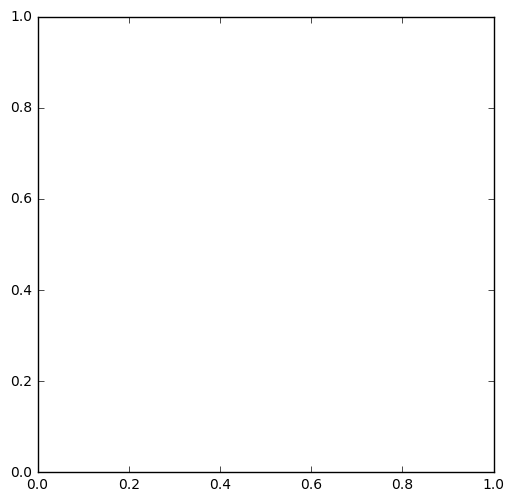

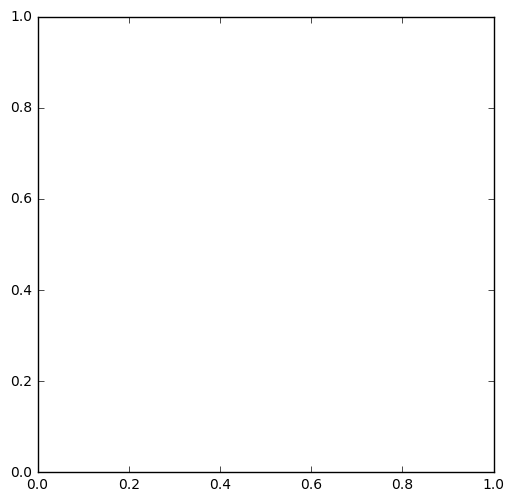

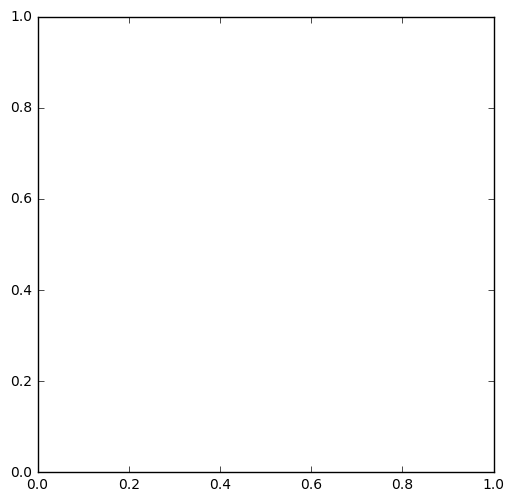

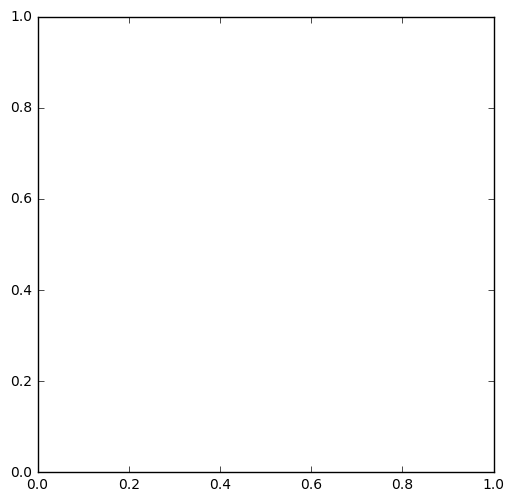

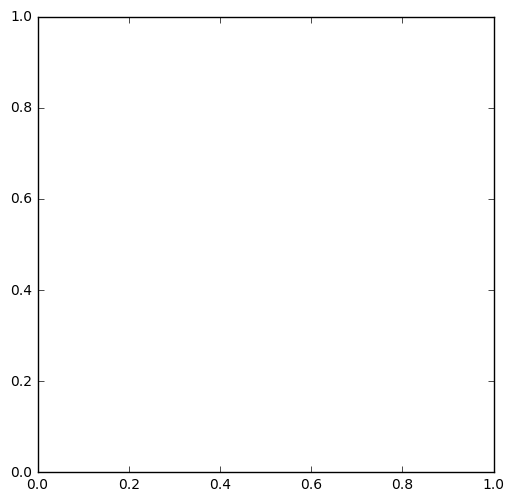

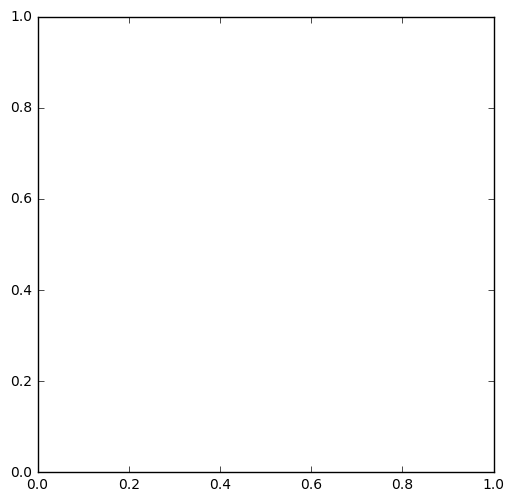

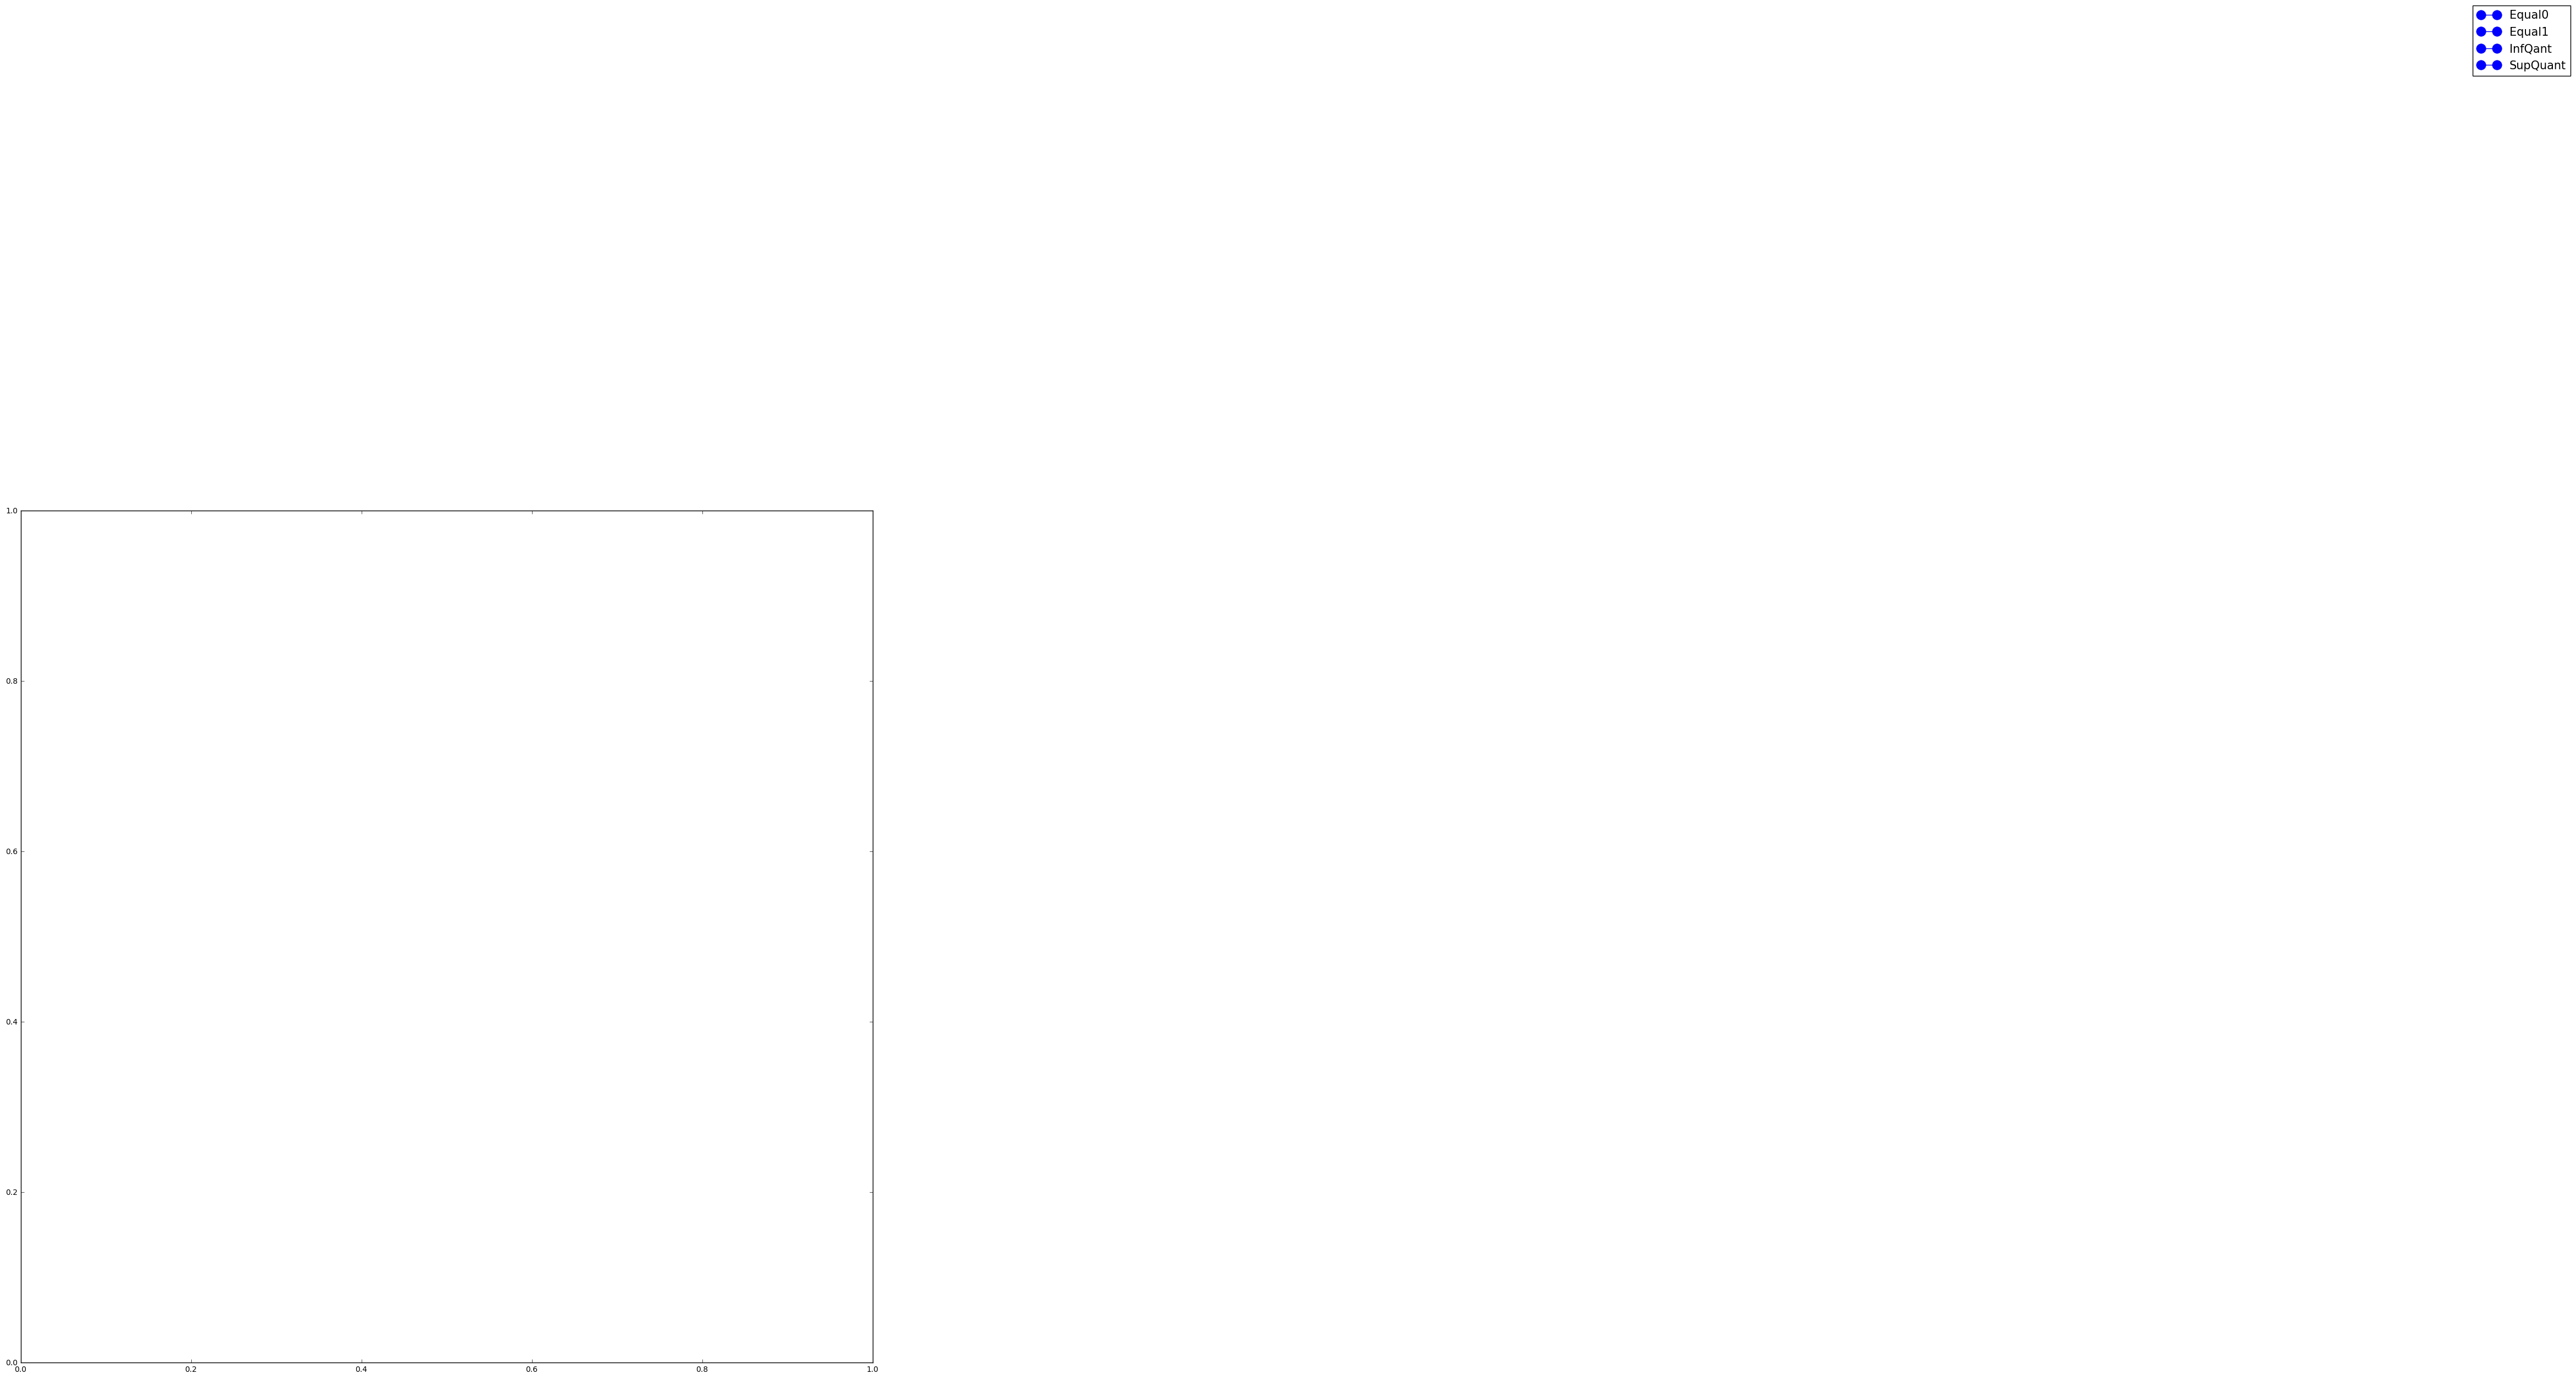

In [51]:
fig = plt.figure(figsize= (20,20))
count = 0
#Build legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0],marker=".", linestyle=None, markersize=25, label=act)for act in ACTIVITY_DIC.values()]
plt.legend(handles=legend_elements,loc='upper right', bbox_to_anchor=(3, 1.6),fontsize=15)
plt.show()

## K-Means

In [69]:
from sklearn.cluster  import  KMeans
from  sklearn.metrics  import confusion_matrix
clust=KMeans(n_clusters=4)
clust.fit(X_Panda)
classe=clust.labels_
print(classe)

[2 2 2 ..., 0 0 0]


In [94]:
X=scale(EchantillonTest[:, 1:50])

In [95]:
pca = PCA()
C = pca.fit(X).transform(X)

In [96]:
np.shape(C)

(5240, 49)

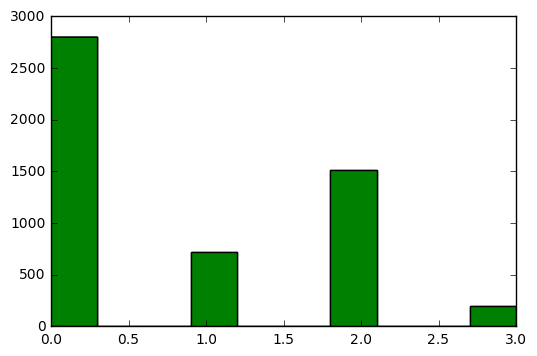

In [92]:
plt.hist(classe)
plt.show()

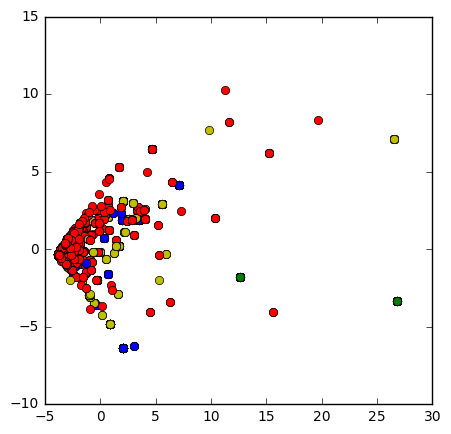

In [97]:

plt.figure(figsize=(5,5))
for i, j, nom in zip(C[:,0], C[:,1], classe):
    color = "red"
    if nom==1  :
        color="blue"
    elif nom==2:
        color="y"
    elif nom==3:
        color="g"
    elif nom==4:
        color="b"
    plt.plot(i, j, "o",color=color)
plt.show()